In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
from tqdm import tqdm
from utils.train_preprocessing import my_processing
from utils.CustomDataset import DataGenerator
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, cohen_kappa_score


import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping

2023-04-14 22:47:44.542329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 22:47:44.690992: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-14 22:47:44.730795: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-14 22:47:45.399246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
label_th = 0.1
seg_time = 30
data_folder = f'/NAS/Benson/Sleep_Apnea/Sleep_Codes/Code_with_data/CNN_LSTM/Model_Training/Data'
info_csv = pd.read_csv(f'{data_folder}/label_{seg_time}s_{int(label_th*100)}_binary.csv')
train_data = []
train_label = []
valid_data = []
valid_label = []
train_ids = ["00000711-100839", "00000781-100816", "00001096-100779", "00000782-100816", "00001118-100779"]
valid_ids = ["00000782-100816"]

for x in range(390*len(train_ids)):
    image = cv2.imread(f'{data_folder}/Segments_{seg_time}s/{info_csv["filename"][x]}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_data.append(image)
    train_label.append(info_csv["label"][x])

    
for x in range(390*len(train_ids), 390*(len(train_ids)+len(valid_ids))):
    image = cv2.imread(f'{data_folder}/Segments_{seg_time}s/{info_csv["filename"][x]}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    valid_data.append(image)
    valid_label.append(info_csv["label"][x])
    
train_label = tf.keras.utils.to_categorical(train_label, 2)
valid_label = tf.keras.utils.to_categorical(valid_label, 2)

print(len(train_data))
print(len(train_label))
print(len(valid_data))
print(len(valid_label))
del info_csv

1950
1950
390
390


In [3]:
train_data = my_processing(dataset = train_data, outsize=448, pre_type="his")
valid_data = my_processing(dataset = valid_data, outsize=448, pre_type="his")
#train_data, train_label = sklearn.utils.shuffle(train_data, train_label)

100%|███████████████████████████████████████████| 390/390 [00:01<00:00, 296.73it/s]


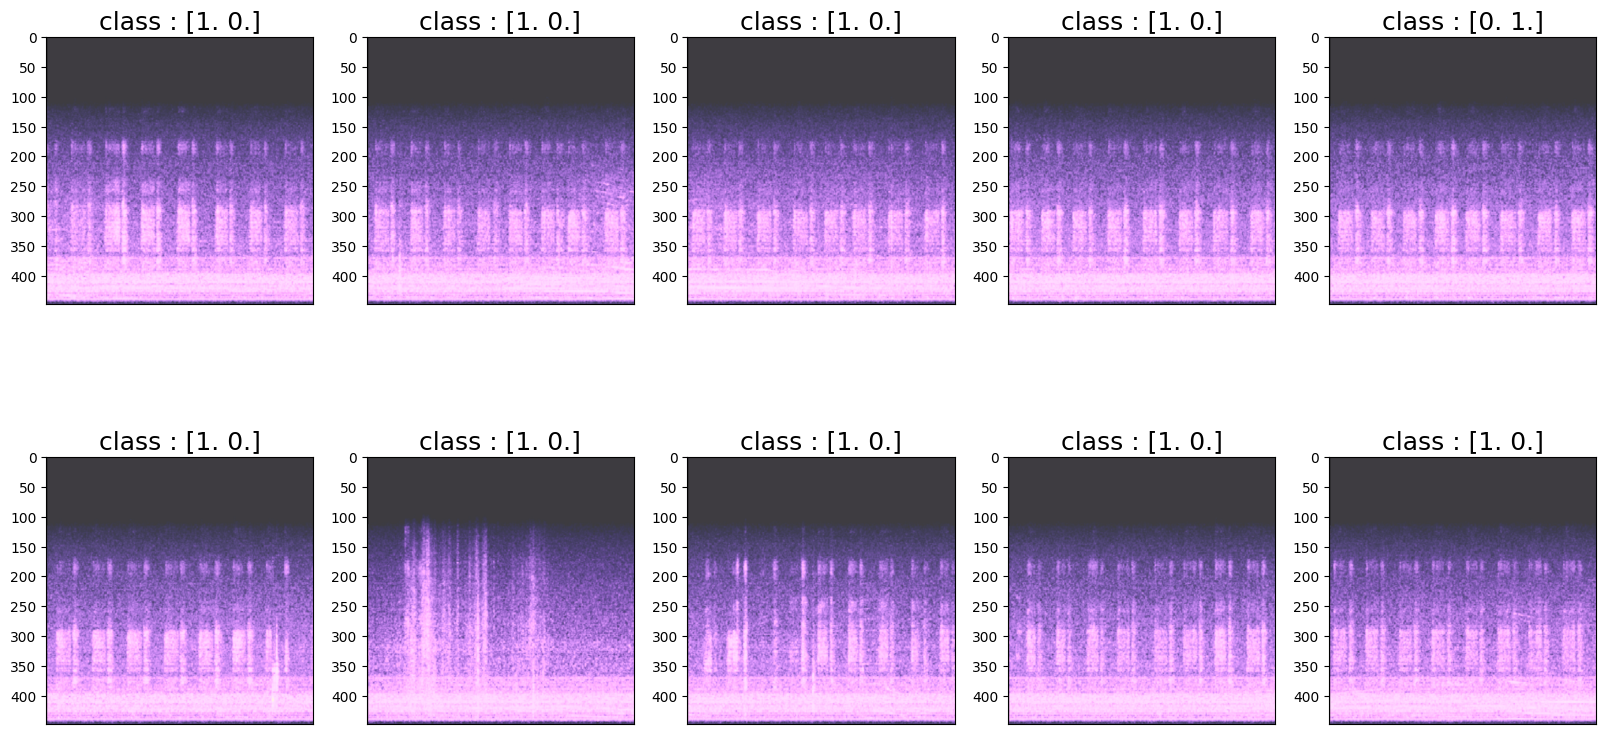

In [4]:
plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)                                    
    plt.title("class : " + str(train_label[i]), 
               fontsize=18)                                        
    plt.xticks([])                                                
    ax.imshow(train_data[i])    

In [5]:
def my_model(timesteps, img_height, img_width, img_color_channels, num_classes):
    
    input_batch = Input(shape = (timesteps, img_height, img_width, img_color_channels))
    
    
    cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(input_batch)
    cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Flatten())(cnn_network)
   
    
    lstm_network = LSTM(12, return_sequences=False, dropout=0.05, recurrent_dropout=0.05)(cnn_network)
    lstm_network = Dense(8,activation='relu')(lstm_network)
    lstm_network = Dropout(0.1)(lstm_network)
    lstm_network = Dense(4,activation='relu')(lstm_network)
    lstm_network = Dropout(0.1)(lstm_network)
    lstm_network = Dense(num_classes, activation='softmax')(lstm_network)
    
    
    full_network = Model(input_batch, lstm_network)
    return full_network

In [6]:
model = my_model(timesteps = 10,
                 img_height = 448,
                 img_width = 448,
                 img_color_channels = 3,
                 num_classes = 2)
model.summary()

2023-04-14 22:48:25.832220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 22:48:28.056521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78963 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:12:00.0, compute capability: 8.0
2023-04-14 22:48:28.057960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78969 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:13:00.0, compute capability: 8.0
2023-04-14 22:48:28.059216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/r

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 448, 448, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 448, 448, 4)  112       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 448, 448, 4)  148       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 448, 448, 4)  16        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 112, 112, 4)  0     

In [7]:
train_dataset = DataGenerator(data = train_data, 
                              label = train_label, 
                              batch_size = 10, 
                              patient_num = len(train_ids), 
                              seg_time = seg_time, 
                              timesteps = 10,
                              return_label = True)

valid_dataset = DataGenerator(data = valid_data, 
                              label = valid_label, 
                              batch_size = 10, 
                              patient_num = len(valid_ids), 
                              seg_time = seg_time, 
                              timesteps = 10,
                              return_label = True)

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              )


num_epoch = 1000
start_time = time.perf_counter()
model_history = model.fit(x = train_dataset,
                          validation_data = valid_dataset,
                          epochs = num_epoch,
                          shuffle = False,
                          workers = 0,
                          callbacks = [EarlyStopping(monitor = 'val_loss',
                                                     patience = 50,
                                                     verbose = 1)]
                   )
print(f'Total time: {time.perf_counter() - start_time} sec')

Epoch 1/2


2023-04-14 22:48:35.177579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-14 22:48:38.073467: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


191/191 [==============================] - 107s 522ms/step - loss: 0.7210 - accuracy: 0.4871 - val_loss: 0.6930 - val_accuracy: 0.5459
Epoch 2/2
191/191 [==============================] - 99s 518ms/step - loss: 0.6934 - accuracy: 0.5144 - val_loss: 0.6879 - val_accuracy: 0.7113
Total time: 206.82878926885314 sec


In [9]:
##training v2

# loss_fn = losses.CategoricalCrossentropy()
# optimizer = optimizers.Adam(learning_rate=1e-5)
# acc_metric = metrics.CategoricalAccuracy()


# def train(timesteps):
#     train_acc_his = []
#     train_loss_his = []
#     val_acc_his = []
#     val_loss_his = []

#     num_epoch = 200
#     batch_size = 10
#     seg_per_person = 11700//seg_time
#     win_per_person = seg_per_person-timesteps+1
#     train_size = (win_per_person)*4
#     start_time = time.perf_counter()
#     for epoch in range(num_epoch):
        
#         id_generator = timestep_id_generator(len(ids), seg_per_person, timesteps)
#         step_size = train_size//batch_size
#         print(f'Training Epoch {epoch+1}')

        
#         for batch in range(step_size + 1):
                 
                
#             if batch == step_size:

#                 if train_size % batch_size == 0:
#                     continue

#                 else:
#                     print([[(n := next(id_generator)), (n+timesteps)]for _ in range(train_size-batch*batch_size)])
#                     print([(n-train_size+batch*batch_size+timesteps), (n+timesteps)])
#                     x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(train_size-batch*batch_size)])
#                     y_batch = train_label[(n-train_size+batch*batch_size+timesteps) : (n+timesteps)]
                    
            
#             elif 1 <= win_per_person*((batch*batch_size)//win_per_person+1) - batch*batch_size <= batch_size-1:
#                 print([[(n := next(id_generator)), (n+timesteps)] for _ in range(batch_size)])
#                 print([[n-batch_size+1, seg_per_person*((batch*batch_size)//win_per_person+1)], 
#                        [seg_per_person*((batch*batch_size)//win_per_person+1)+timesteps-1, n+timesteps]])
#                 x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(batch_size)])
#                 y_batch = np.concatenate((train_label[n-batch_size+1 : seg_per_person*((batch*batch_size)//win_per_person+1)],
#                                          train_label[seg_per_person*((batch*batch_size)//win_per_person+1)+timesteps-1 : n+timesteps]),
#                                          axis = 0)
                
            
#             else:
#                 print([[(n := next(id_generator)), (n+timesteps)] for _ in range(batch_size)])
#                 print([(n-batch_size+timesteps), (n+timesteps)])
#                 x_batch = np.array([train_data[(n := next(id_generator)) : (n+timesteps)] for _ in range(batch_size)])
#                 y_batch = train_label[(n-batch_size+timesteps):(n+timesteps)]

        
#             with tf.GradientTape() as tape:
#                 y_pred = model(x_batch, training = True)
#                 loss = loss_fn(y_batch, y_pred)
#             gradients = tape.gradient(loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#             acc_metric.update_state(y_batch, y_pred)

#         print(f'accuracy: {acc_metric.result()}, loss: {loss}')
#         train_acc_his.append(tf.get_static_value(acc_metric.result()))
#         train_loss_his.append(tf.get_static_value(loss))
#         acc_metric.reset_state()

#         y_val_pred = model(x_test, training=False)
#         val_loss = loss_fn(y_test, y_val_pred)
#         acc_metric.update_state(y_test, y_val_pred)

#         print(f'val_accuracy: {acc_metric.result()}, val_loss: {val_loss}')
#         print()
#         val_acc_his.append(tf.get_static_value(acc_metric.result()))
#         val_loss_his.append(tf.get_static_value(val_loss))
#         acc_metric.reset_state()

#     print(f'Total time: {time.perf_counter()-start_time} sec')
#     return train_acc_his, train_loss_his, val_acc_his, val_loss_his

# results = train(timesteps = timestep)

In [10]:
# def num():
#     for i in range(10):
#         yield i
# test = num()
# num_list = []
# for test_num in num():
#     num_list.append(test_num)
# print(num_list[0:6])
# new_list = [num_list[(n := next(test)):n+2] for _ in range(4)]
# print(new_list)

In [11]:
# plt.plot(results[1], label="training_loss")
# plt.plot(results[3], label="validation_loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Learning Curve")
# plt.legend(loc='best')
# plt.show()

In [12]:
# plt.plot(results[0])
# plt.plot(results[2])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

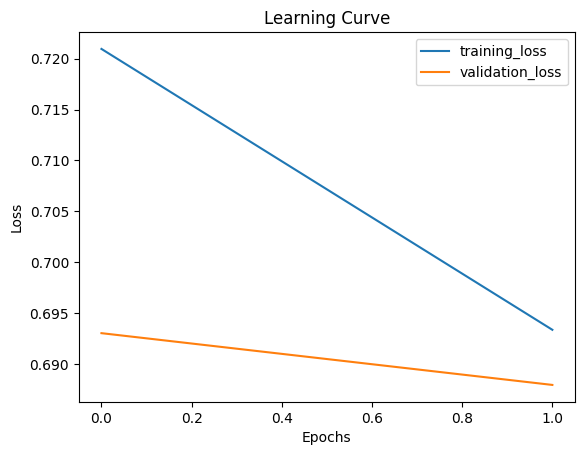

In [13]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

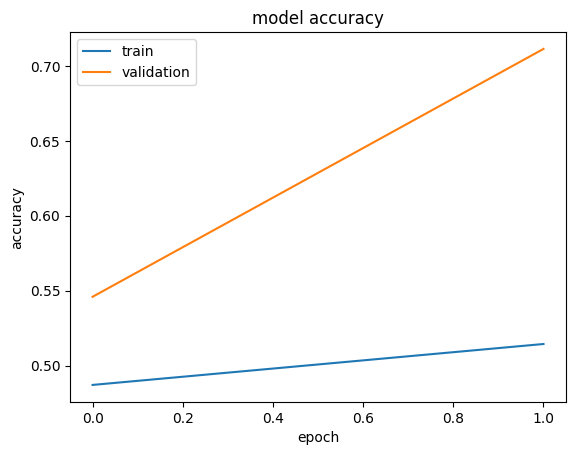

In [14]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
# test_pred = model(np.array([train_data[n:(n+10)] for n in range(30)]))
# print(test_pred)
# print(train_label[9:40])

In [23]:
test_dataset = DataGenerator(data = valid_data, 
                             label = valid_label, 
                             batch_size = 10, 
                             patient_num = len(valid_ids), 
                             seg_time = seg_time, 
                             timesteps = 10,
                             return_label = False)

pred = model.predict(test_dataset)
print("predictions: ")
print(pred[0:5])
print("answer : ")
print(valid_label[0:5])

39/39 [==============================] - 9s 234ms/step
predictions: 
[[0.4991702  0.5008298 ]
 [0.4974933  0.5025067 ]
 [0.4975647  0.50243527]
 [0.50047684 0.49952322]
 [0.4990525  0.50094754]]
answer : 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


(390, 2)
(381, 2)
ROC_AUC_Score: 0.7649264016759468



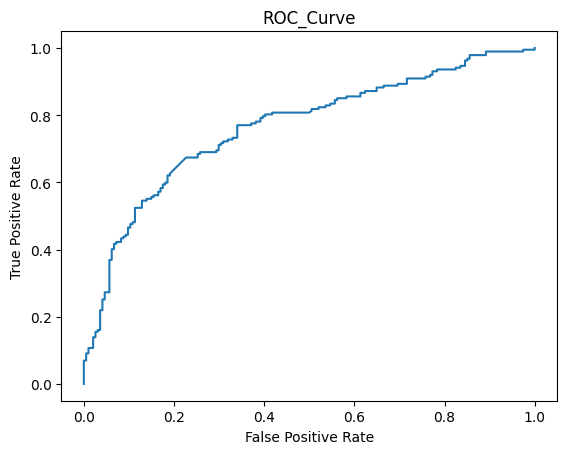

In [24]:
print(valid_label.shape)
print(pred.shape)
print(f'ROC_AUC_Score: {roc_auc_score(valid_label[9:], pred)}')
print()
fpr, tpr, _ = roc_curve(valid_label[9:][:,1], pred[:,1])
plt.plot(fpr, tpr)
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [26]:
print('Confusion Matrix: ')
print(confusion_matrix(valid_label[9:].argmax(-1), pred.argmax(-1)))
print()
print(f'Cohen_Kappa_Score: {cohen_kappa_score(valid_label[9:].argmax(-1), pred.argmax(-1))}')

Confusion Matrix: 
[[159  35]
 [ 75 112]]

Cohen_Kappa_Score: 0.42013946538269964


In [ ]:
# model.save("lstm.h5(1)")